<a href="https://colab.research.google.com/github/bksat90/LLM/blob/main/LLM_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install transformers
!pip install datasets

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import seaborn as sns
import os


from sklearn.metrics import confusion_matrix, roc_curve
from datasets import load_dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer)

In [46]:
BATCH_SIZE = 16
EPOCHS = 3

In [55]:
# load data
data = load_dataset("SetFit/emotion")

Repo card metadata block was not found. Setting CardData to empty.


In [56]:
print(data)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})


In [61]:
data.set_format(type="pandas")
df = data["train"][:]
df.head()

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [79]:
counts = df.label_text.value_counts()

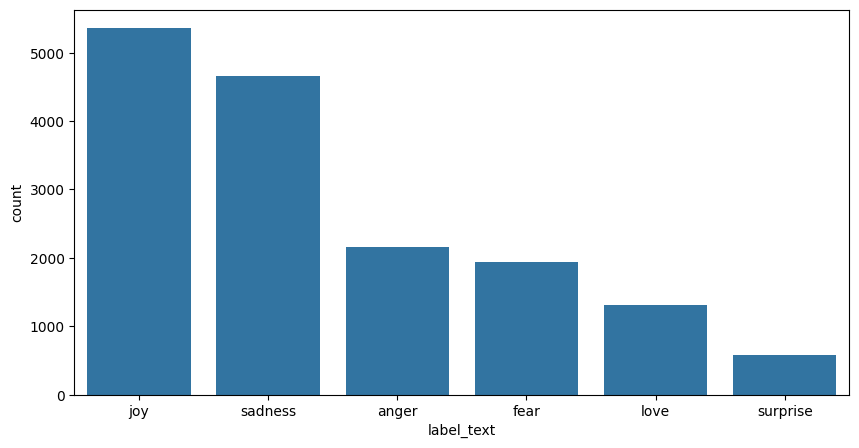

In [81]:
plt.figure(figsize=(10,5))
sns.barplot(counts)
plt.show()

In [75]:
counts

,count
label_text,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572
